Install dependencies

In [ ]:
!pip install -r ../../requirements.txt

Read data.

In [1]:
import csv

data_folder = '../../datasets/comparison-based-dataset/'

scores_path = data_folder + 'website_scores.csv'
images_path = data_folder + 'images/'

def get_scores():

    images = []
    scores = []

    with open(scores_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0

        for row in csv_reader:
            if line_count == 0:

                line_count += 1
            else:

                scores.append(float(row[1]))
                line_count += 1
                image_name = row[0]
                image_name = image_name[5:]

                images.append(images_path + image_name + '.png')


    return (images, scores)


train_images, scores = get_scores()

Shuffle the training set.

In [2]:
import random

# np.random.seed(2000)

temp = list(zip(train_images, scores))
random.shuffle(temp)

train_images, scores = zip(*temp)


Display the first 3 images to make sure everything is ok. 

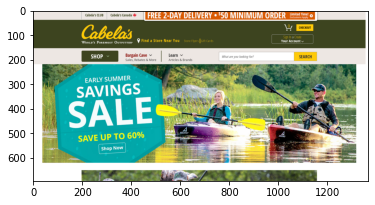

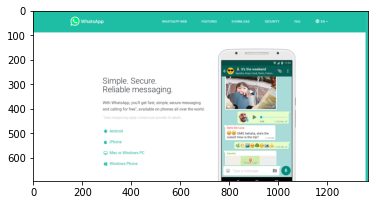

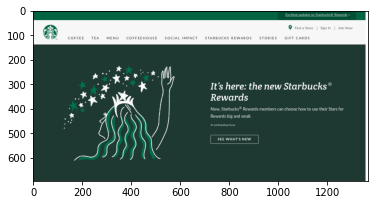

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.image as mping
for ima in train_images[0:3]:
    img = mping.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

Read and reshape images. 

In [4]:
import cv2
import numpy as np 

width = 256 
height = 192 
channels = 3

def read_and_process_images(list_of_images):
  X = []
  
  for image in list_of_images:
    X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (width, height), 
                        interpolation=cv2.INTER_AREA))
  return X


X = np.array(read_and_process_images(train_images))
y = np.array(scores)

ModuleNotFoundError: No module named 'cv2'

Display shapes to check everything is ok.

In [ ]:
n = len(X)

print('Length of X is: ', n)
print('Shape of X is: ', X.shape)
print('Shape of y is: ', y.shape)

Display the first 2 images to make sure everything is ok. 

In [ ]:
plt.figure(figsize=(25,15))
num = 3

for i in range(num):
  plt.subplot(num, 1, i+1)
  plt.imshow(X[i])

The architecture that will be used for the CNN is AlexNet. First, we define the LRN (Local Response Normalization) layer.

In [ ]:
from keras import layers
from keras import models
from keras import optimizers
from keras import regularizers
from keras import initializers
from keras.preprocessing.image import ImageDataGenerator

from keras.layers.core import Layer
from keras import backend as K

class LRN(Layer):
    
    def __init__(self, n=5, alpha=0.0001, beta=0.75, k=2, **kwargs):
        self.n = n
        self.alpha = alpha
        self.beta = beta
        self.k = k
        super(LRN, self).__init__(**kwargs)

    def build(self, input_shape):
        self.shape = input_shape
        super(LRN, self).build(input_shape)

    def call(self, x, mask=None):
        if K.common.image_dim_ordering == "th":
            _, f, r, c = self.shape
        else:
            _, r, c, f = self.shape
        half_n = self.n // 2
        squared = K.square(x)
        pooled = K.pool2d(squared, (half_n, half_n), strides=(1, 1),
                         padding="same", pool_mode="avg")
        if K.common.image_dim_ordering == "th":
            summed = K.sum(pooled, axis=1, keepdims=True)
            averaged = (self.alpha / self.n) * K.repeat_elements(summed, f, axis=1)
        else:
            summed = K.sum(pooled, axis=3, keepdims=True)
            averaged = (self.alpha / self.n) * K.repeat_elements(summed, f, axis=3)
        denom = K.pow(self.k + averaged, self.beta)
        return x / denom
    
    def get_output_shape_for(self, input_shape):
        return input_shape

Define the loss function (Euclidean Distance Loss) and the metric (RMSE) that will be used

In [ ]:
from keras import backend as K
 
def rmse(y_true, y_pred):
	return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def euclidean_distance_loss(y_true, y_pred):
  return 0.5 * K.mean(K.square(y_pred - y_true), axis=-1)

Define a function that calculates Pearson correlation. 

In [ ]:
from scipy import stats

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''
    N = len(x)
    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(N-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

Construct the CNN. The first 5 convolutional layers of the network are initialized with weights of the pretrained model on the [Rating-Based Web Aesthetics dataset](https://github.com/calista-ai/website-aesthetics-datasets). 

In [ ]:
l = 0.001 # weight decay
epochs = 100
decay = 1e-4 
base_lr = 0.001
input_shape = X[0].shape
batch_size = 10
pretrained_model_filename = '../../pretrained-models/calista_rating_based.h5'

def create_model(transfer_learning = False):
  im_data = layers.Input(shape=input_shape, dtype='float32', name='im_data')

  conv1 = layers.Conv2D(96, kernel_size=(11, 11), strides=(4, 4), name='conv1', 
                  activation='relu', input_shape=input_shape, 
                  kernel_regularizer=regularizers.l2(l))(im_data)

  pool1 = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)
  norm1 = LRN(name="norm1")(pool1)

  layer1_1 = layers.Lambda(lambda x: x[:, :, :, :48])(norm1)
  layer1_2 = layers.Lambda(lambda x: x[:, :, :, 48:])(norm1)

  conv2_1 = layers.Conv2D(128, kernel_size=(5, 5), strides=(1, 1),
                  activation='relu',
                  padding='same', 
                  name='conv2_1', 
                  kernel_regularizer=regularizers.l2(l))(layer1_1)

  conv2_2 = layers.Conv2D(128, kernel_size=(5, 5), strides=(1, 1),
                  activation='relu',
                  padding='same', 
                  name='conv2_2',
                  kernel_regularizer=regularizers.l2(l))(layer1_2)

  conv2 = layers.Concatenate(name='conv_2')([conv2_1, conv2_2])

  pool2 = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv2)
  norm2 = LRN(name="norm2")(pool2)

  conv3 = layers.Conv2D(384, kernel_size=(3, 3), strides=(1, 1), activation='relu', 
                  name='conv3',
                  padding='same',
                  kernel_regularizer=regularizers.l2(l))(norm2)

  layer3_1 = layers.Lambda(lambda x: x[:, :, :, :192])(conv3)
  layer3_2 = layers.Lambda(lambda x: x[:, :, :, 192:])(conv3)

  conv4_1 = layers.Conv2D(192, kernel_size=(3, 3), strides=(1, 1),
                  activation='relu', 
                  padding='same',
                  name='conv4_1',
                  kernel_regularizer=regularizers.l2(l))(layer3_1)

  conv4_2 = layers.Conv2D(192, kernel_size=(3, 3), strides=(1, 1),
                  activation='relu', 
                  padding='same',
                  name='conv4_2',
                  kernel_regularizer=regularizers.l2(l))(layer3_2)

  conv4 = layers.Concatenate(name='conv_4')([conv4_1, conv4_2])

  layer4_1 = layers.Lambda(lambda x: x[:, :, :, :192])(conv4)
  layer4_2 = layers.Lambda(lambda x: x[:, :, :, 192:])(conv4)

  conv5_1 = layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1),
                  activation='relu',
                  padding='same', 
                  name='conv5_1',
                  kernel_regularizer=regularizers.l2(l))(layer4_1)

  conv5_2 = layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1),
                  activation='relu',
                  padding='same', 
                  name='conv5_2',
                  kernel_regularizer=regularizers.l2(l))(layer4_2)

  conv5 = layers.Concatenate(name='conv_5')([conv5_1, conv5_2])

  pool5 = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv5)

  flat = layers.Flatten()(pool5)
  fc6 = layers.Dense(1024, activation='relu', name='fc6', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
                  bias_initializer='zeros',
                  kernel_regularizer=regularizers.l2(l))(flat)
  drop6 = layers.Dropout(0.5)(fc6)

  fc7 = layers.Dense(512, activation='relu', name='fc7', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
                  bias_initializer='zeros',
                  kernel_regularizer=regularizers.l2(l))(drop6)
  drop7 = layers.Dropout(0.5)(fc7)

  fc8 = layers.Dense(1, name='fc8', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
                  bias_initializer='zeros')(drop7)

  model = models.Model(inputs=im_data, outputs=fc8)

  if (transfer_learning == True):
    model.load_weights(pretrained_model_filename, by_name = True)
    print('Transfer learning completed')

  sgd = optimizers.SGD(lr=base_lr, momentum=0.9, decay=decay, nesterov=True)
  model.compile(loss=euclidean_distance_loss , optimizer=sgd, metrics=[rmse])

  return model 


Create a file to save model's predictions.

In [ ]:
from datetime import datetime
import gc

date_time = datetime.now().strftime("%m_%d_%Y__%H_%M_%S")
output_filename = 'results_' + date_time + '.csv'

with open(output_filename, "w") as f:
    writer = csv.writer(f)
    writer.writerow(["images", "gt_scores", "predictions"])

predictions = []

Use Leave-one-out cross validation (LOOCV) to evalute the model.

In [ ]:
k_start = 0
k = n

for i in range(k_start, k):
  print('**** PROGRESS: %d/%d ****' % (i, k))
  if i == 0:
    X_train = X[(i+1):]
    y_train = y[(i+1):]
  elif i == n-1:
    X_train = X[:i]
    y_train = y[:i]
  else:
    X_train = np.concatenate((X[:i], X[(i+1):]), axis = 0)
    y_train = np.concatenate((y[:i], y[(i+1):]), axis = 0)

  X_val = X[i]
  X_val = X_val.reshape(1, height, width, channels)
  y_val = y[i]

  ntrain = len(X_train)
  # check shapes
  # print('X_train length : ' + str(ntrain))
  # print('X_train : ' + str(X_train.shape))
  # print('y_train : ' + str(y_train.shape))
  # print('X_val : ' + str(X_val.shape))

  train_datagen = ImageDataGenerator(rescale = 1./255)

  val_datagen = ImageDataGenerator(rescale = 1./255)

  train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)

  model = create_model(transfer_learning=True)

  history = model.fit_generator(train_generator, 
                                steps_per_epoch = ntrain // batch_size,
                                epochs = epochs)

  val_data = val_datagen.flow(X_val, batch_size=1).next()

  pred = float(model.predict(val_data))
  predictions.append(pred)

  # save output 
  new_row = [train_images[i], scores[i], pred]
  with open(output_filename, "a") as f:
    writer = csv.writer(f)
    writer.writerow(new_row)

  del X_train, X_val, y_train, y_val, model
  gc.collect()

print('********* DONE *********')

Create a scatterplot to check the relationship between ground truth and predicted scores.

In [ ]:
from numpy.polynomial.polynomial import polyfit

y_val = np.array(scores[0:k])
predictions = np.array(predictions)

b, m = polyfit(y_val, predictions, 1)

fig = plt.figure()
plt.scatter(y_val, predictions, c='c')
plt.plot(y_val, b + m * y_val, '-', c='b')
plt.xlabel('User ratings')
plt.ylabel('Predicted ratings')

plt.show()


Calculate the Pearson correlation and the RMSE between ground truth and predicted scores.

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

corr, p, lo, hi = pearsonr_ci(y_val, predictions)
print('Pearsons correlation: r=%.2f, p=%.2e, CI=[%.2f, %.2f]' % (corr, p, lo, hi))
rmse_test = sqrt(mean_squared_error(y_val, predictions))
print('RMSE: %.3f' % rmse_test)

Plot the distribution of ground truth scores and the distribution of predictions.

In [ ]:
import seaborn as sns

fig = plt.figure()
sns.set(color_codes=True)

bins = np.linspace(1, 9, num=15)

sns.distplot(y_val, bins=bins, label='User ratings')

sns.distplot(predictions, bins=bins, label='Predicted ratings')

plt.legend()

plt.show()